In [1]:
using Revise
using SSMCMain, SSMCMain.ModifiedMiCRM
using SSMCMain.ModifiedMiCRM.RandomSystems, SSMCMain.ModifiedMiCRM.GraphAnalysis
using Base.Threads, OhMyThreads


In [2]:
using PythonCall
sys = pyimport("sys")
sys.path.append(projectdir("community-simulator"))
cs = pyimport("community_simulator")
np = pyimport("numpy")

Python: <module 'numpy' from '/Users/stevenredford/Dropbox/Python/SSMC/.CondaPkg/.pixi/envs/default/lib/python3.12/site-packages/numpy/__init__.py'>

In [3]:
using CairoMakie
using GLMakie
CairoMakie.activate!()
# display(GLMakie.Screen(), f.figure)

In [4]:
tools = pyimport("community_simulator.usertools")

Python: <module 'community_simulator.usertools' from '/Users/stevenredford/Dropbox/Python/SSMC/community-simulator/community_simulator/usertools.py'>

In [5]:
# a little test
N = 31
R = 30
R0val = 100.0
N_classes = 3


N_per_class = round(N / N_classes)
N_gen = Int(N - N_per_class*N_classes)
println(N_gen)

R_classes = 3
R_per_class = round(R / R_classes)

l = fill(0.0,N,R)
l[:,1] .= 0.999;
#println(typeof(N_per_class))

Ds=1e-10
Dr=1

K = fill(0.0,R)
K[1] = R0val;


assumptions = tools.a_default

assumptions["SA"] = N_per_class*np.ones(N_classes)
assumptions["MA"] = R_per_class*np.ones(R_classes)
assumptions["Sgen"] = N_gen
assumptions["muc"] = 2
assumptions["q"] = 0.5
assumptions["R0_food"] = R0val
assumptions["n_wells"] = 1
assumptions["food"] = 0
assumptions["S"] = N  # Number of species at the beginning
assumptions["l"] = np.array(l[1,:])  # leakage
assumptions["sparsity"] = 0.8
assumptions["supply"] = "external" 



c, DT = tools.MakeMatrices(assumptions);

# first convert to Julia arrays
C = pyconvert(Array{Float64,2}, c)
C[:,1] .= 1.0


# give each strain its own consumption and release matrix
D_iab = fill(0.0, N,R,R)
for i in 1:N
    c, DT = tools.MakeMatrices(assumptions)
    D = pyconvert(Array{Float64,2}, DT)
    D_iab[i,:,:] .= transpose(D);
end


params = BMMiCRMParams(fill(1.0,N),
        fill(1.0,R),
        fill(0.4,N),
        K,
        fill(1.0,R),
        l,
        C,
        D_iab)

u0 = make_u0_smart(params;
    u0=:onlyN,
    u0rand=0.
)

p = make_mmicrm_problem(params, u0, 200)
s = solve(p; callback=make_timer_callback(60));

#first define some diffusions
DS = fill(0.0, N + R)
DS[1:N] .= Ds
DS[N+1:end] .= Dr

ks = LinRange(0., 100., 1000)
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(usol, params, 0))

lambda_func = linstab_make_k_func(params, DS, usol)
full_linstab_func = linstab_make_k_func(params, Ds, usol; returnobj=:full)

lambdas = lambda_func.(ks)
mrl = maximum(x->maximum(real,x), lambdas)

# get the maximum real eigenvalue at k=0
#println(length(lambdas))
zr_mrl = maximum(real, lambdas[1])


total_biomass = sum(usol[1:N])

1
[-0.004094712340829559, 0.0009366146343147463, 4.1574230473998155e-17, 0.004347575011921246, -0.00028058974205097674, -1.1735007150656974e-12, 0.0028740900129949026, -9.795794422131673e-18, 0.0037540679354190597, 0.0038166479985096372, -6.078645369068359e-22, -0.0019684669615413057, -1.009524295204699e-17, 0.004984524735600194, -7.742009032267908e-10, -6.078645369068359e-22, -1.0501455748909296e-15, 0.001884930830720929, 0.0009366146343147463, -6.078645369068359e-22, -0.0015370925599381942, 0.002906526908046604, 0.00655773788512272, -6.078645369068359e-22, -7.028092957917994e-21, -3.75625366113495e-20, -1.4369906146680116e-14, -0.0019117690977255865, 0.007938580339528946, -1.8118795344559415e-21, -2.7198745043264755e-21, -0.0003541603078478228, 7.336027556092972e-6, 1.2887340940181957e-5, -5.5149042885727084e-6, 1.5231646852242875e-5, 6.654672724870636e-6, -5.478377330669915e-6, 3.515397386522068e-7, -1.5451021126988707e-6, -5.7904653532919736e-5, -4.999909219183373e-14, 4.3487871215

92.63766410128953

In [6]:
out = full_linstab_func.(ks)

1000-element Vector{Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}}:
 Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}(ComplexF64[0.003584150712464251 + 0.0im, 0.0014305339986128162 + 0.0im, -0.016139854528936716 + 0.0im, -0.02638177625294802 + 0.0im, -0.03249187348965394 + 0.0im, -0.10392017378974824 - 0.02750894402574684im, -0.10392017378974824 + 0.02750894402574684im, -0.12348986368896898 - 0.13199092934067636im, -0.12348986368896898 + 0.13199092934067636im, -0.2051855654237847 + 0.0im  …  -11.969566128628147 + 0.0im, -12.65808270761756 + 0.0im, -13.113389284712369 + 0.0im, -15.365143788743842 + 0.0im, -15.814504558731803 + 0.0im, -26.94042249540132 + 0.0im, -27.335664258914633 + 0.0im, -29.547645807868122 + 0.0im, -32.756144848884354 + 0.0im, -93.55422987608628 + 0.0im], ComplexF64[-0.17445905011874427 + 0.0im 0.00686750517850868 + 0.0im … -9.51335440653245e-5 + 0.0im -0.0007812940925046066 + 0.0im; 0.062040837560871684 + 0.0im 0.27876151

In [7]:
map(x->maximum(real, x.values), out)

1000-element Vector{Float64}:
 0.003584150712464251
 0.0035841507124677848
 0.003584150712468723
 0.0035841507124679773
 0.003584150712467087
 0.003584150712472232
 0.003584150712477778
 0.0035841507124789434
 0.003584150712478693
 0.003584150712485776
 ⋮
 0.0035841509407929205
 0.003584150941258135
 0.003584150941713426
 0.0035841509421794034
 0.0035841509426401785
 0.003584150943105636
 0.0035841509435728374
 0.0035841509440341997
 0.0035841509444957402

In [8]:
_, maxi = findmax(x->maximum(real,x.values), out)
maxes = out[maxi]
_, ii = findmax(real, maxes.values)
mx_vec = maxes.vectors[:,ii]

61-element Vector{ComplexF64}:
     0.17445858285516697 + 0.0im
   -0.062040841000948685 + 0.0im
  -2.525570540011129e-19 + 0.0im
    -0.26464352253730433 + 0.0im
   0.0003040343230356347 + 0.0im
  -2.333560895590863e-14 + 0.0im
    -0.23011373217045278 + 0.0im
  -2.496754881567007e-17 + 0.0im
    -0.28240906496000645 + 0.0im
    -0.26350713996286756 + 0.0im
                         ⋮
 -0.00012896815412324114 + 0.0im
   1.4710801643987922e-7 + 0.0im
    3.322975452076352e-5 + 0.0im
  -5.2086567946308787e-5 + 0.0im
  -4.288391476298449e-20 + 0.0im
  0.00021612476698816804 + 0.0im
     8.22013215704144e-6 + 0.0im
  -0.0064129998336894265 + 0.0im
    0.005522870180055805 + 0.0im

Vector{Float64}


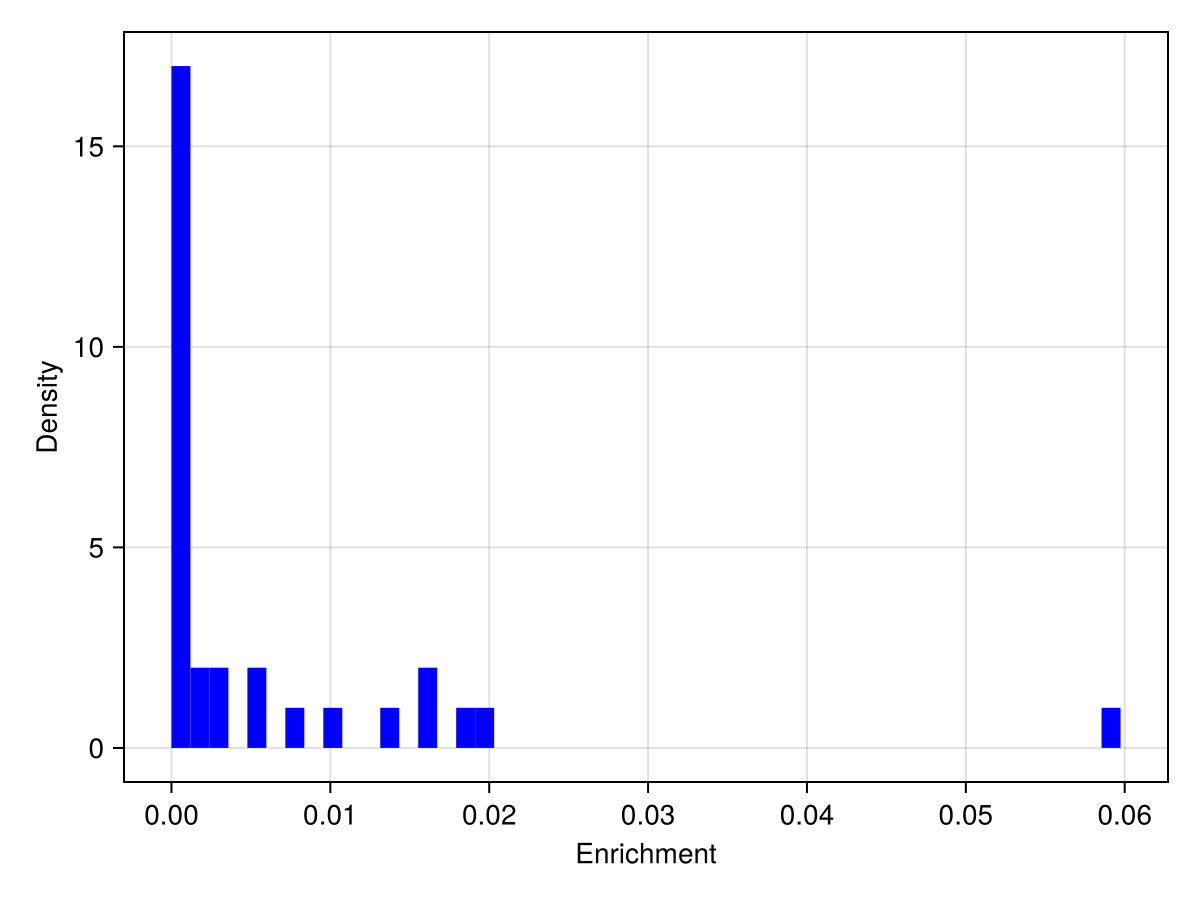

In [9]:
strns_ss = usol[1:N]
strns_eig = mx_vec[1:N]

enrch = abs.(strns_eig) .* abs.(strns_eig)./(abs.(strns_ss) .+ abs.(strns_eig))
#enrch = (strns_eig .* strns_eig)

println(typeof(enrch))

# plot the distribution of enrichment
fig = Figure()
ax = Axis(fig[1, 1], xlabel="Enrichment", ylabel="Density")
hist!(ax, abs.(enrch), bins=50, color=:blue, label="Enrichment Distribution")
fig


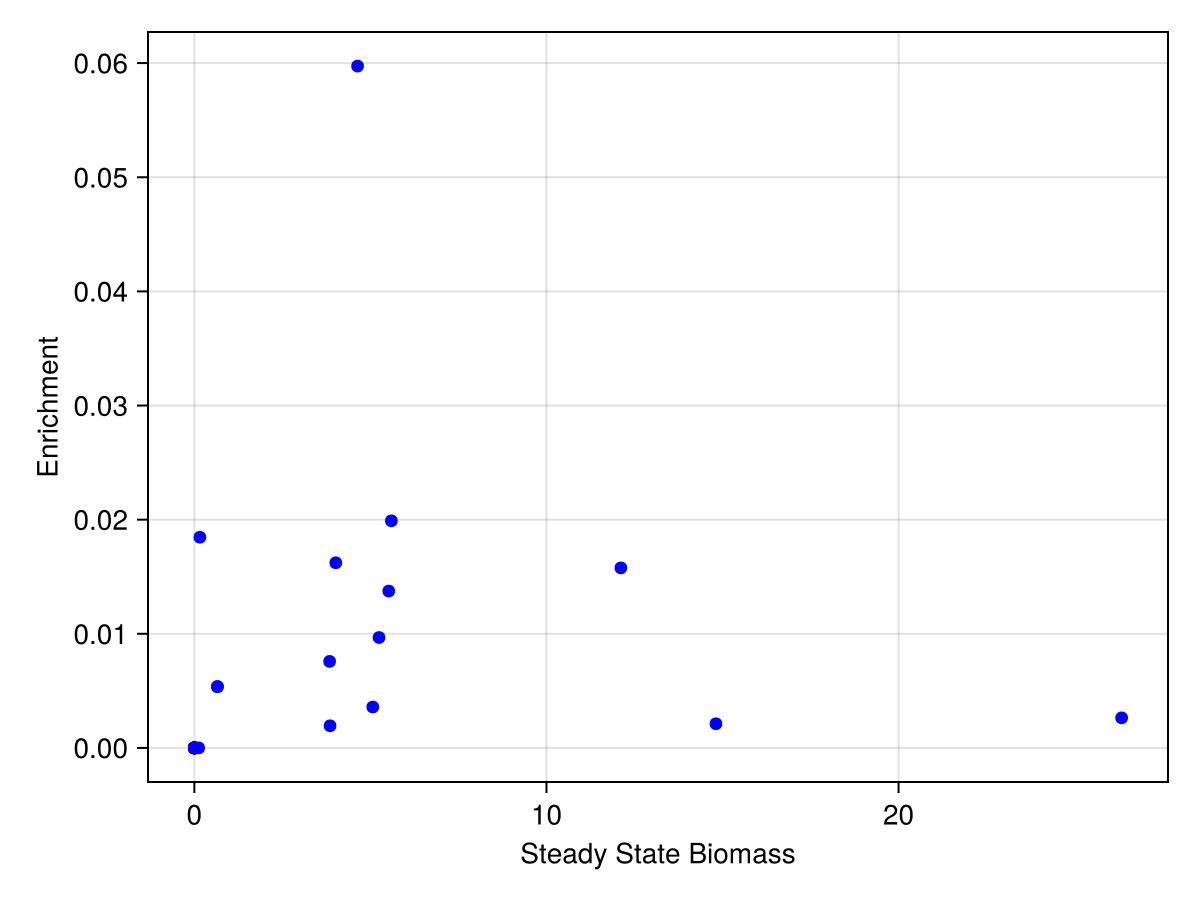

In [10]:
# scatter enrichment vs steady state biomass
fig2 = Figure()
ax2 = Axis(fig2[1, 1], xlabel="Steady State Biomass", ylabel="Enrichment")
scatter!(ax2, real(strns_ss), abs.(enrch), color=:blue, label="Enrichment vs Steady State Biomass")
fig2

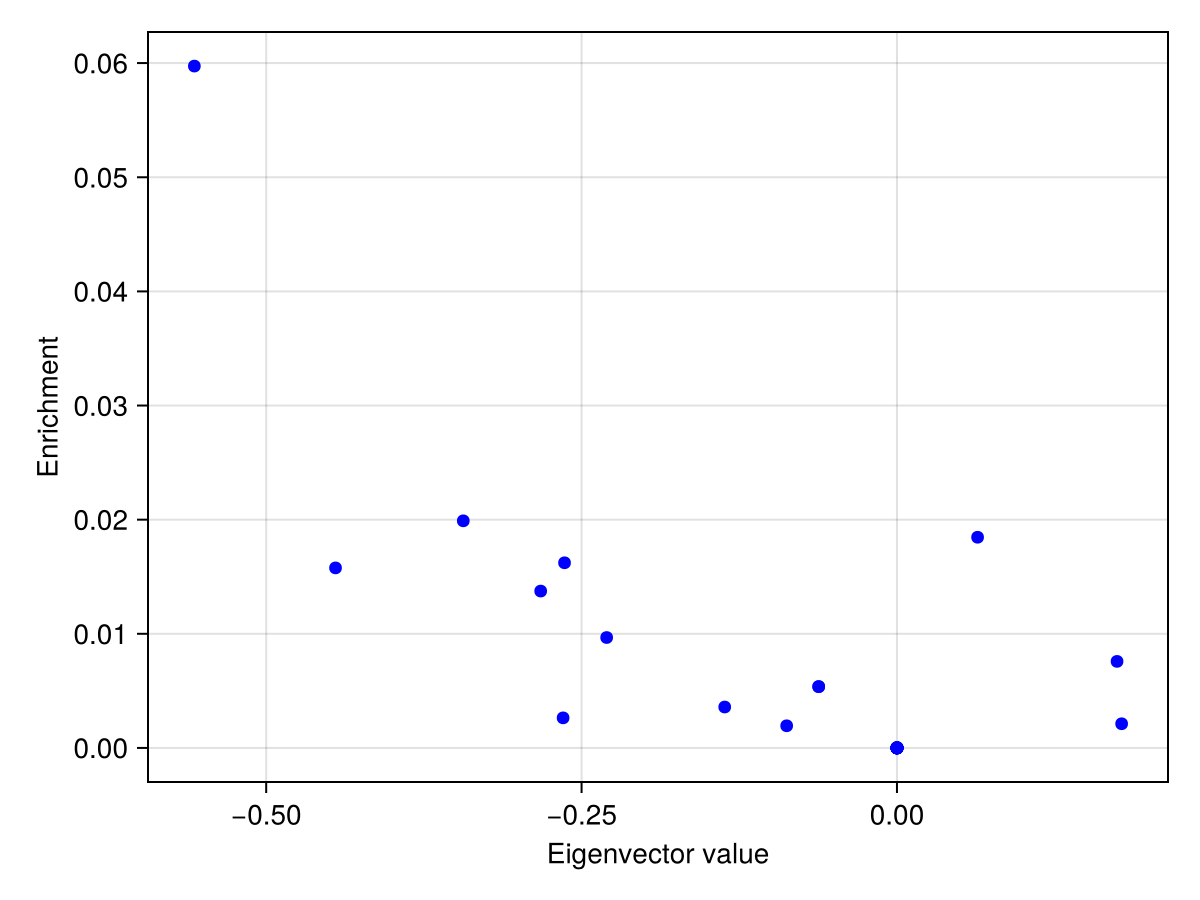

In [11]:
# scatter enrichment vs eigenvalue
fig3 = Figure()
ax3 = Axis(fig3[1, 1], xlabel="Eigenvector value", ylabel="Enrichment")
scatter!(ax3, real(strns_eig), abs.(enrch), color=:blue, label="Enrichment vs Eigenvector value")
fig3

In [12]:
function solve_and_LSA(N,R; R0val=100, N_classes=3, single_k=false,leak_one=false)

    N_per_class = round(N / N_classes)
    N_gen = Int(N - N_per_class*N_classes)
    #println(N_gen)

    R_classes = 3
    R_per_class = round(R / R_classes)


    l = fill(0.0,N,R)
    if leak_one
        l[:,1] .= 0.999;
    else
        l_dist = Beta(0.1, 0.3)
        for i in 1:N
            l[i,:] .= rand(l_dist, R)
        end
    end
    #println(typeof(N_per_class))

    Ds=1e-10
    Dr=1

    if single_k
        K = fill(0.0,R)
        K[1] = R0val;
    else
        K_dist = Beta(0.1, 0.3)
        K = rand(K_dist, R).*R0val
    end


    assumptions = tools.a_default

    assumptions["SA"] = N_per_class*np.ones(N_classes)
    assumptions["MA"] = R_per_class*np.ones(R_classes)
    assumptions["Sgen"] = N_gen
    assumptions["muc"] = 2
    assumptions["q"] = 0.5
    assumptions["R0_food"] = R0val
    assumptions["n_wells"] = 1
    assumptions["food"] = 0
    assumptions["S"] = N  # Number of species at the beginning
    assumptions["l"] = np.array(l[1,:])  # leakage
    assumptions["sparsity"] = 0.8
    assumptions["supply"] = "external" 



    c, DT = tools.MakeMatrices(assumptions);

    # first convert to Julia arrays
    C = pyconvert(Array{Float64,2}, c)
    C[:,1] .= 1.0


    # give each strain its own consumption and release matrix
    D_iab = fill(0.0, N,R,R)
    for i in 1:N
        c, DT = tools.MakeMatrices(assumptions)
        D = pyconvert(Array{Float64,2}, DT)
        D_iab[i,:,:] .= transpose(D);
    end


    params = BMMiCRMParams(fill(1.0,N),
            fill(1.0,R),
            fill(0.4,N),
            K,
            fill(1.0,R),
            l,
            C,
            D_iab)

    u0 = make_u0_smart(params;
        u0=:onlyN,
        u0rand=0.
    )

    p = make_mmicrm_problem(params, u0, 200)
    s = solve(p; callback=make_timer_callback(60));

    #first define some diffusions
    DS = fill(0.0, N + R)
    DS[1:N] .= Ds
    DS[N+1:end] .= Dr

    ks = LinRange(0., 100., 10000)
    usol = s.u[end]
    #usol = sssol.u
    #usol = Symbolics.value.(getindex.(symsol[2], 2))
    #show(uninplace(mmicrmfunc!)(usol, params, 0))

    lambda_func = linstab_make_k_func(params, DS, usol)
    full_linstab_func = linstab_make_k_func(params, Ds, usol; returnobj=:full)

    lambdas = lambda_func.(ks)
    mrl = maximum(x->maximum(real,x), lambdas)

    # get the maximum real eigenvalue at k=0
    #println(length(lambdas))
    zr_mrl = maximum(real, lambdas[1])
    

    total_biomass = sum(usol[1:N])
    
    return mrl, zr_mrl, total_biomass

end


solve_and_LSA (generic function with 1 method)

In [13]:
npts = 20
nrep = 100

R0s = LinRange(1, 100, npts)
#println("R0s: ", R0s)

biomasses = fill(0.0, npts, nrep)
mrls = fill(0.0, npts, nrep)
zero_eigs = fill(0.0, npts, nrep)

for i in 1:npts
    for j in 1:nrep

        #println(R0s[i])
        Rval = R0s[i]
        
        mrl, zr_mrl, biomass = solve_and_LSA(31, 30; R0val=Rval)
        
        mrls[i,j] = mrl
        zero_eigs[i,j] = zr_mrl
        biomasses[i,j] = biomass
    end
end

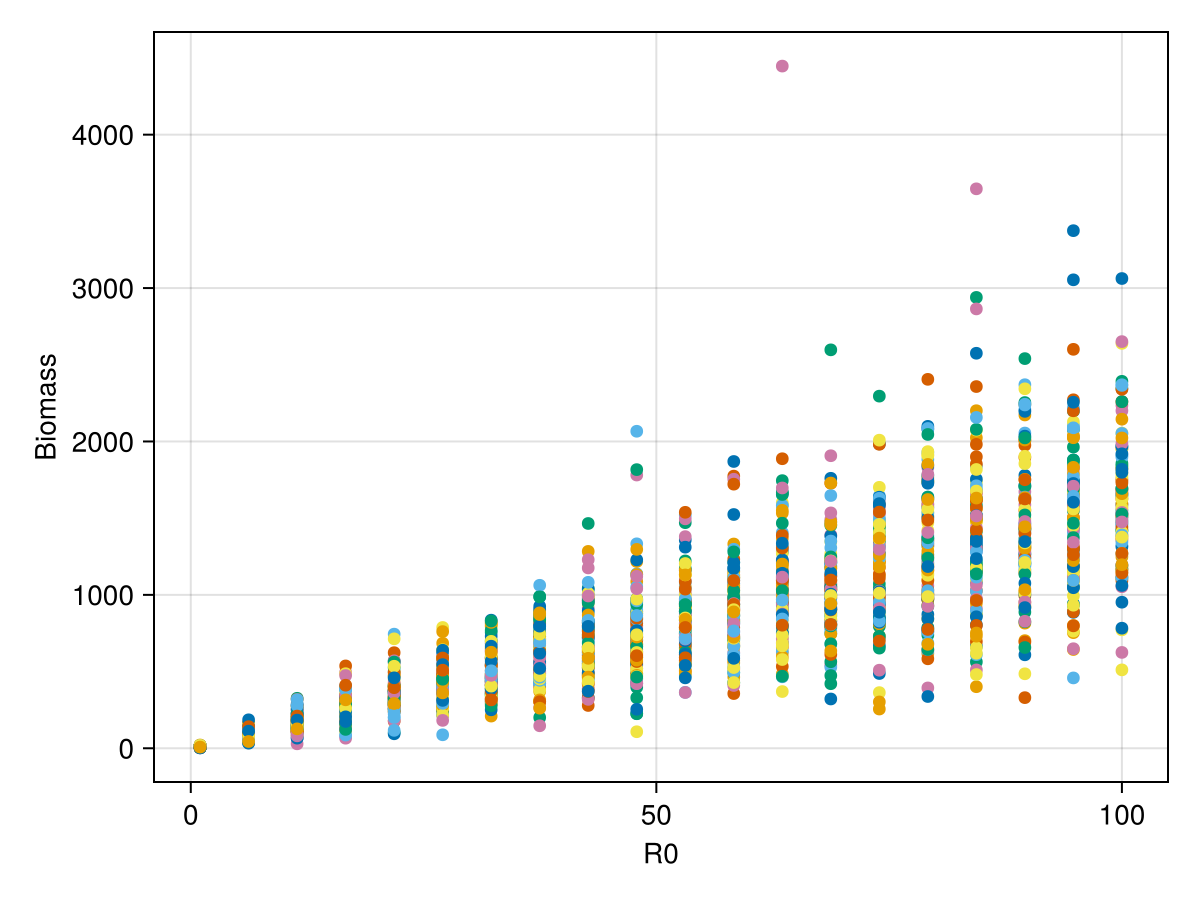

CairoMakie.Screen{IMAGE}


In [14]:
# scatter plot all biomasses against R0s
fig = Figure()
ax = Axis(fig[1, 1], xlabel="R0", ylabel="Biomass")
for i in 1:nrep
    scatter!(ax, R0s, biomasses[:,i], label="Rep $i")
end
#plot!(ax, R0s, vec(mean(biomasses, dims=2)), color=:"black", label="Mean Biomass", markersize=10)
#scatter!(ax, R0s, vec(std(biomasses, dims=2)), color=:"red", label="Std Dev Biomass", markersize=10)
display(fig)

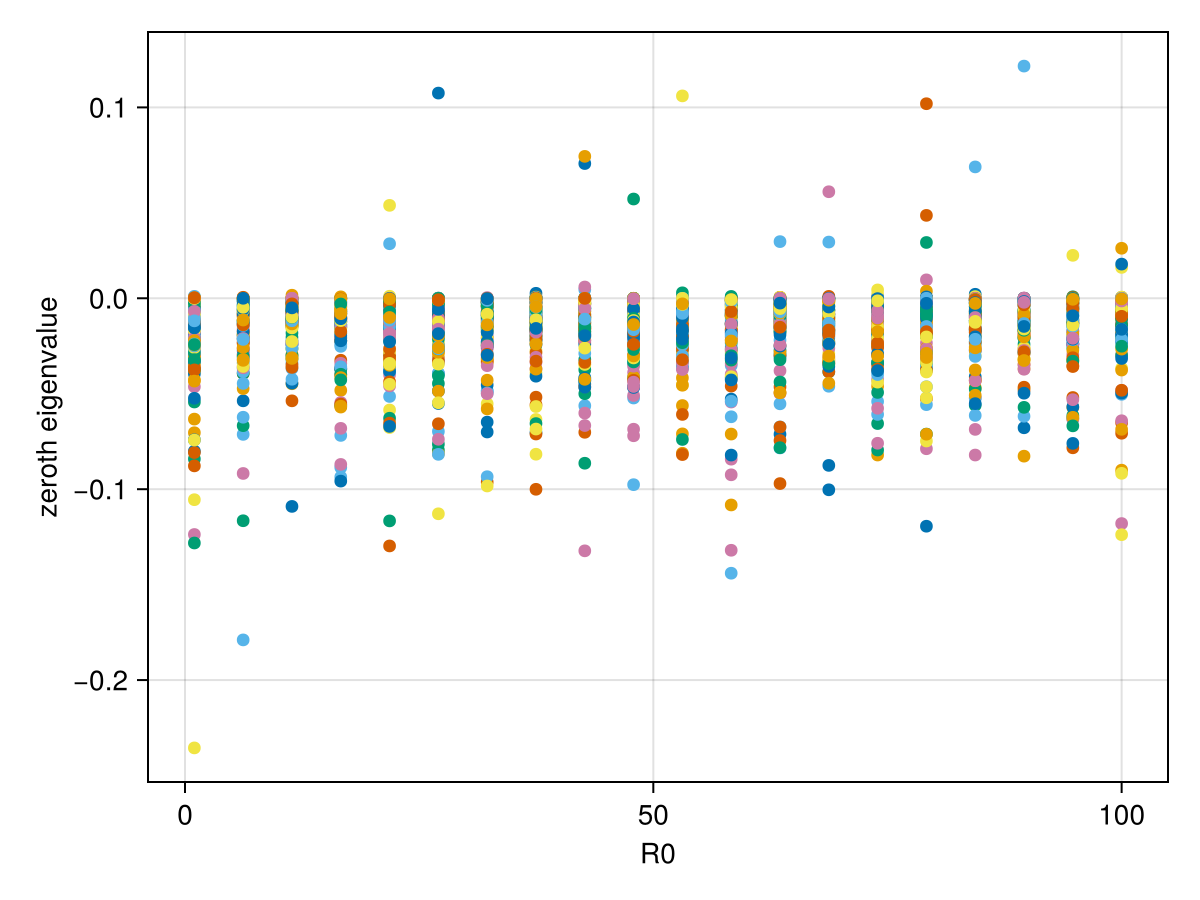

CairoMakie.Screen{IMAGE}


In [15]:
# scatter plot all maximum real eigenvalues against R0s
fig3 = Figure()
ax3 = Axis(fig3[1, 1], xlabel="R0", ylabel="zeroth eigenvalue")
for i in 1:nrep
    scatter!(ax3, R0s, zero_eigs[:,i], label="Rep $i")
end
#plot!(ax, R0s, vec(mean(biomasses, dims=2)), color=:"black", label="Mean Biomass", markersize=10)
#scatter!(ax, R0s, vec(std(biomasses, dims=2)), color=:"red", label="Std Dev Biomass", markersize=10)
display(fig3)

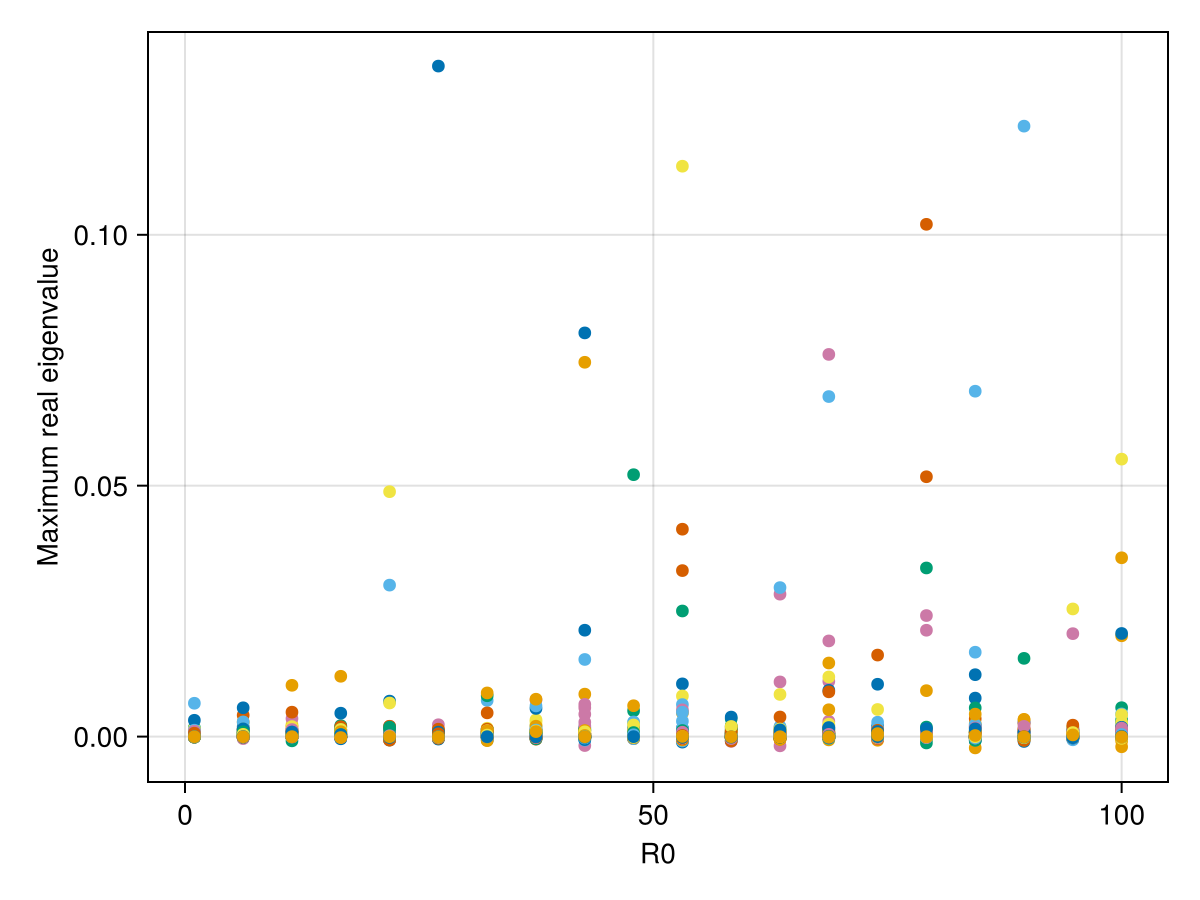

CairoMakie.Screen{IMAGE}


In [16]:
# scatter plot all maximum real eigenvalues against R0s
fig2 = Figure()
ax2 = Axis(fig2[1, 1], xlabel="R0", ylabel="Maximum real eigenvalue")
for i in 1:nrep
    scatter!(ax2, R0s, mrls[:,i], label="Rep $i")
end
#plot!(ax, R0s, vec(mean(biomasses, dims=2)), color=:"black", label="Mean Biomass", markersize=10)
#scatter!(ax, R0s, vec(std(biomasses, dims=2)), color=:"red", label="Std Dev Biomass", markersize=10)
display(fig2)

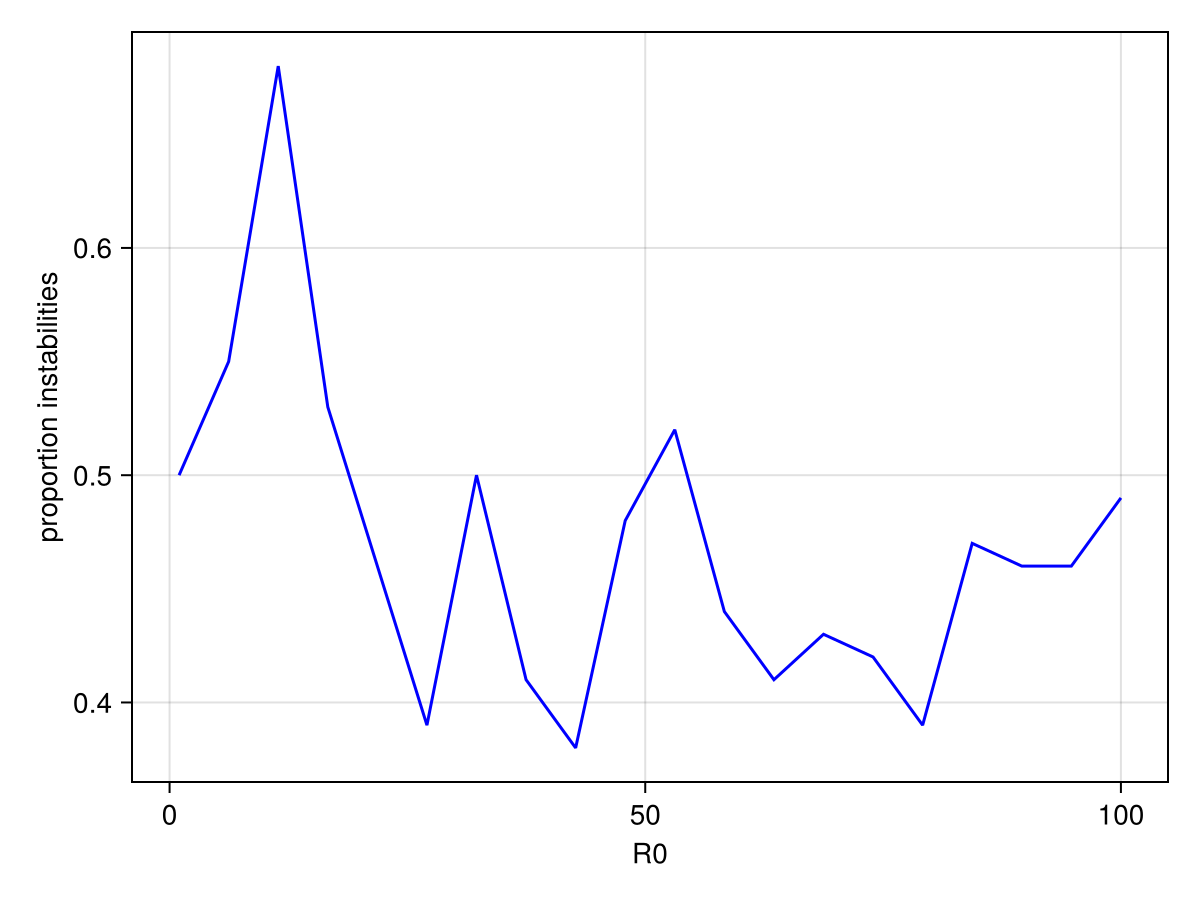

In [17]:
zr_eigs = fill(0.0, npts)
potent = fill(0.0, npts)
zers = fill(0.0, npts)
for i in 1:npts
    zr_eigs[i] = count(zero_eigs[i,:] .> 0.0)
    potent[i] = count(mrls[i,:] .> 0.0)
    zers[i] = count(biomasses[i,:] .< 0.1)
end

fig4 = Figure()
ax4 = Axis(fig4[1, 1], xlabel="R0", ylabel="proportion instabilities")
#plot!(ax4, R0s, potent ./ nrep, color=:red, label="Proportion Naive Instability")
lines!(ax4, R0s, (potent - zr_eigs) ./ (nrep .- zers), color=:blue, label="Proportion Real Instability")
fig4
#plot!(ax, R0s, vec(mean(biomasses, dims

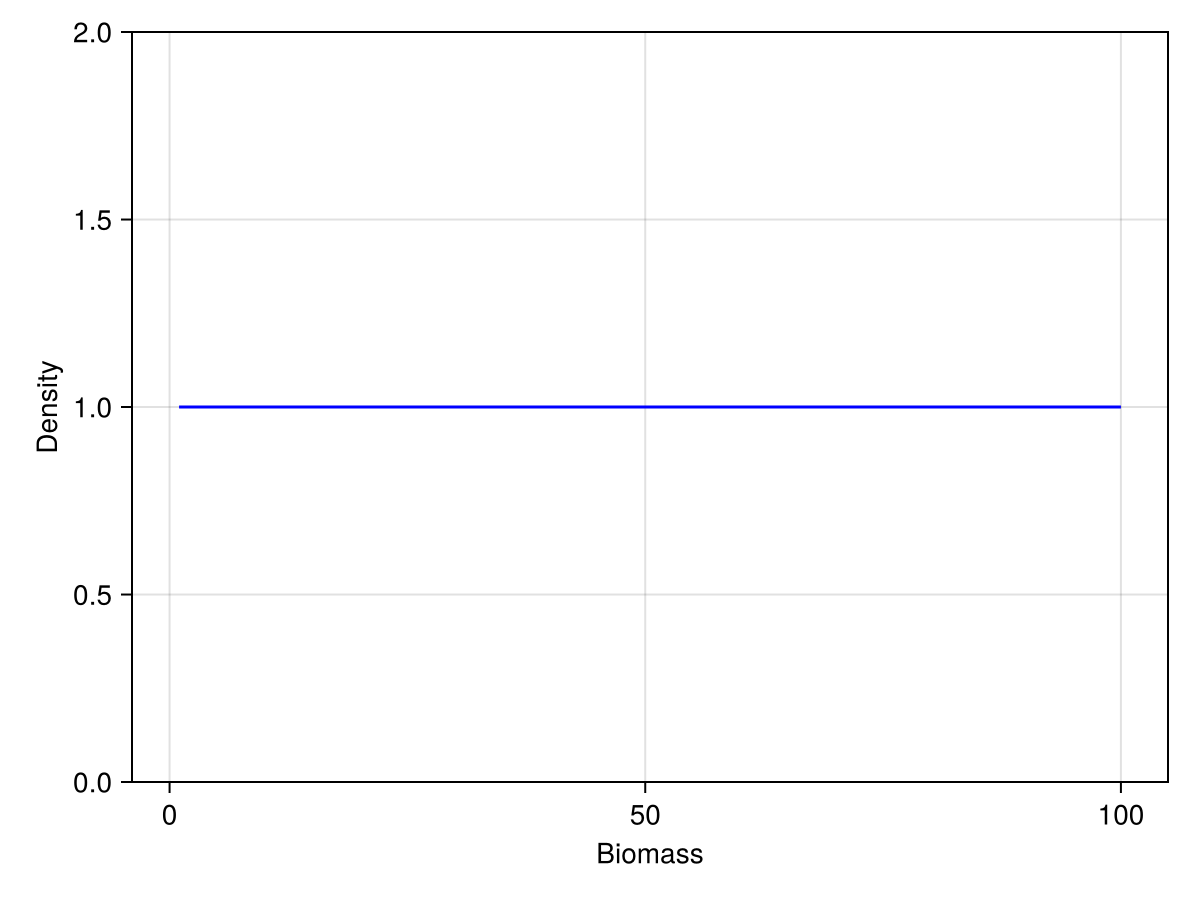

In [18]:
# plot a histogram of biomasses at a single R0
nonzer = fill(0, npts)

for i in 1:npts
    bm = biomasses[i,:]
    nonzer[i] = count(bm .> 0.1)
end

fig5 = Figure()
ax5 = Axis(fig5[1, 1], xlabel="Biomass", ylabel="Density")
lines!(ax5, R0s, nonzer ./ nrep, color=:blue, label="Non-zero Biomass Proportion")
fig5

In [54]:
# visualize the matrices

fig = Figure()
ax = Axis(fig[1, 1], title = "Consumption Matrix",aspect = N/R)
heatmap!(ax, C, colormap = :grays)
ax = Axis(fig[1, 2], title = "Release Matrix",aspect = 1)
heatmap!(ax, D, colormap = :grays)
display(fig)

UndefVarError: UndefVarError: `D` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [12]:
nrep = 100
R0 = 10
#println("R0s: ", R0s)

biomasses = fill(0.0, nrep)
mrls = fill(0.0, nrep)
zero_eigs = fill(0.0, nrep)

for j in 1:nrep
    #println(R0s[i])
    
    mrl, zr_mrl, biomass = solve_and_LSA(31, 30; R0val=R0)
    
    mrls[j] = mrl
    zero_eigs[j] = zr_mrl
    biomasses[j] = biomass
end

zr_eigs = count(zero_eigs .> 0.0)
potent = count(mrls .> 0.0)


57

In [13]:

println("percent naieve instability: ", (potent) / nrep)
println("percent proper instability: ", (potent - zr_eigs) / nrep)
println(biomasses)

percent naieve instability: 0.57
percent proper instability: 0.51
[1.6874764524750768e-32, 4.839722509388931, 38.1914751292942, -2.0974467462923064e-6, 3.16030426864844e-7, 2.5757418309506794e-7, 6.684316212952539e-33, 6.754743340950204, 24.411061269916722, 38.10198974631731, 7.257387347364788, -1.1755486360148117e-11, 8.114448600504611e-10, 9.32077900107059, 6.146571358157365, 2.592010633038479, 3.37398195141864e-7, 3.844583518109274, 31.38290824303616, 9.879560485017474e-10, 5.622905273543284, 23.72622961076511, 2.2138820260751504, 5.782798704077799e-7, -1.433987359663316e-7, 1.0832611207581278e-9, 19.17023659322324, 6.805516693853451, 7.452245747540148e-7, 15.08060939519214, -9.428516385055636e-10, 8.89515504427711e-33, 3.941555481059726e-8, 6.916370030781205e-7, 1.0941617566930586, 11.524916475092873, -5.4116170469855576e-8, -1.0909093921252944e-8, -2.0085587417687102e-7, 12.107938049933523, -3.303092676165355e-7, 23.18050738338327, 4.388180881603486, 2.285742902249365, 21.95424207

In [81]:
# set up Jan's solver

params = BMMiCRMParams(fill(1.0,N_tot),
            fill(1.0,R_tot),
            fill(0.4,N_tot),
            K,
            fill(1.0,R_tot),
            l,
            C,
            D_iab)

u0 = make_u0_smart(params;
    u0=:onlyN,
    u0rand=0.
)

p = make_mmicrm_problem(params, u0, 200)
s = solve(p; callback=make_timer_callback(60));

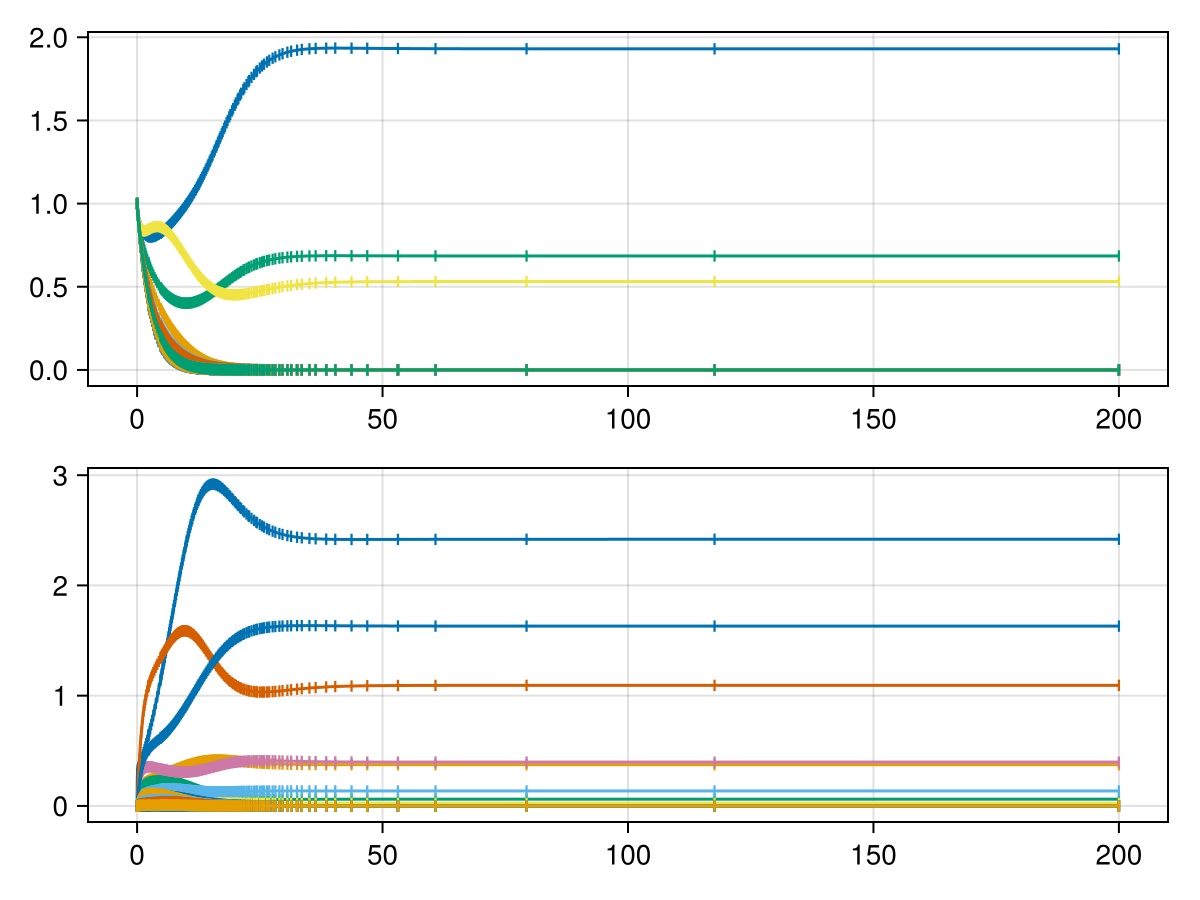

61-element Vector{Float64}:
 1.9304943719096899
 5.507978722120802e-9
 9.62511619346572e-12
 1.0415062396624374e-11
 2.5607962224150826e-10
 7.961212865092135e-12
 3.395636842388584e-11
 7.961212858585125e-12
 7.961212862994178e-12
 0.6850364911557677
 ⋮
 1.996754231585947e-8
 3.360950332141949e-5
 2.8671290957496865e-21
 3.278085554452028e-12
 5.0042364460709345e-6
 3.243981244427933e-9
 1.8006236003108677e-11
 8.073586795582259e-6
 3.314712108034229e-10

In [82]:
check_mmicrmparams(params)
display(plot_mmicrm_sol(s))
s[end]

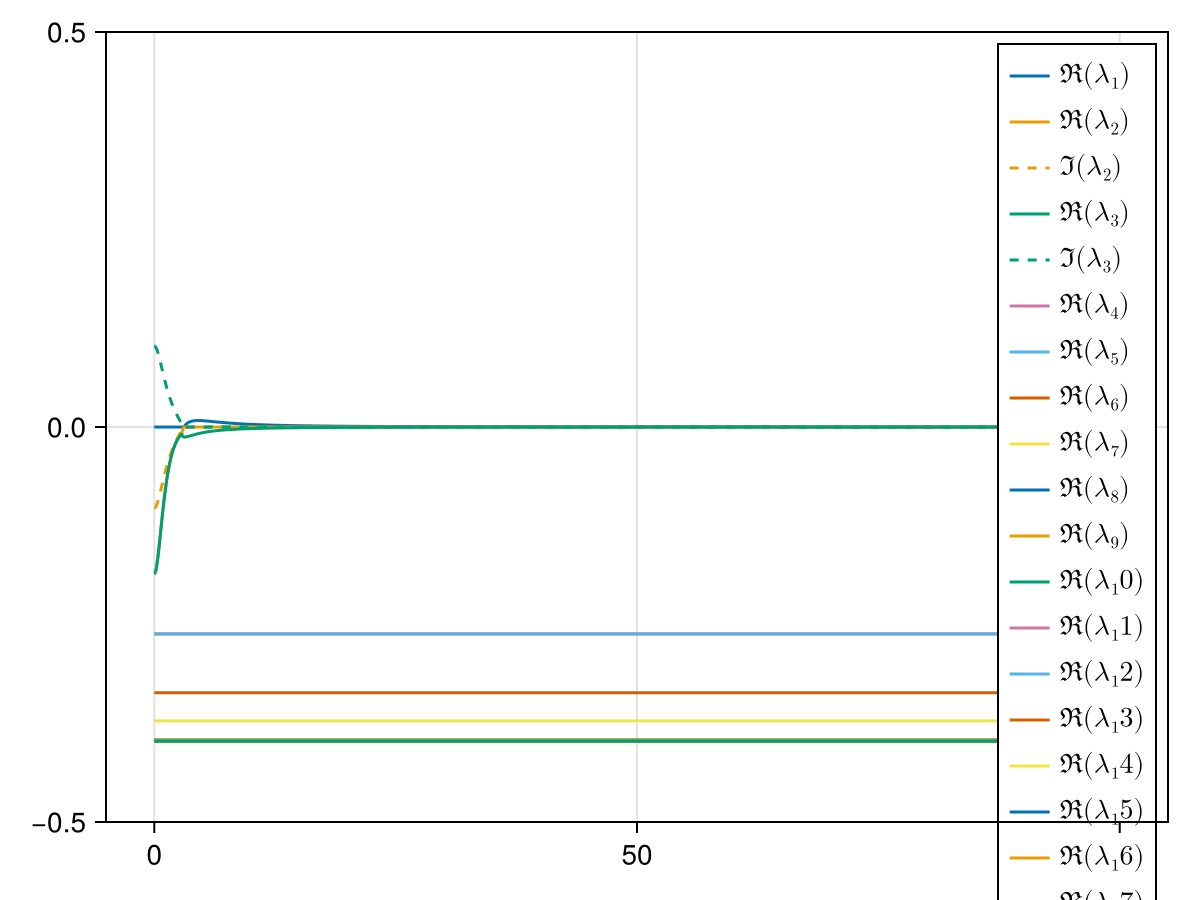

In [83]:
#LSA

#first define some diffusions
DS = fill(0.0, N_tot + R_tot)
DS[1:N_tot] .= Ds
DS[N_tot+1:end] .= Dr

ks = LinRange(0., 100., 10000)
usol = s.u[end]
#usol = sssol.u
#usol = Symbolics.value.(getindex.(symsol[2], 2))
show(uninplace(mmicrmfunc!)(usol, params, 0))

lambda_func = linstab_make_k_func(params, DS, usol)
full_linstab_func = linstab_make_k_func(params, Ds, usol; returnobj=:full)

lambdas = lambda_func.(ks)
mrl = maximum(x->maximum(real,x), lambdas)
@show mrl

faa = plot_linstab_lambdas(ks, lambdas)
ylims!(faa.axis, (-0.5, 0.5))
# xlims!(faa.axis, (0., 2.))
faa

In [63]:
nthreads()

6

In [67]:
ssize = (200,)
dx = 0.01

# baseu0 = nssol
baseu0 = make_u0_smart(params; u0=:onlyN)
su0 = expand_u0_to_size(ssize, baseu0)
su0 = perturb_u0_uniform_prop(get_Ns(params)..., su0, 0.1, 0.1)



spaceps = change_bsmmicrmparams(params)#=; space=make_cartesianspace_smart(1;
    dx,
    bcs=Periodic()),
    usenthreads=nthreads()
)=#
@show spaceps.usenthreads spaceps.mmicrm_params.usenthreads

sp = make_smmicrm_problem(spaceps, su0, 100000);

MethodError: MethodError: no method matching change_bsmmicrmparams(::BMMiCRMParams{Nothing, Float64})
The function `change_bsmmicrmparams` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  change_bsmmicrmparams(!Matched::BSMMiCRMParams; mmicrm_params, Ds, space, usenthreads, nospace_usenthreads, kwargs...)
   @ SSMCMain ~/Dropbox/Python/SSMC/src/SSMCMain/src/ModifiedMiCRM/params_basearray.jl:243


In [65]:
@time sps = solve(sp, QNDF(); maxiters=1000)
print_spatial_solution_stats(sps)

UndefVarError: UndefVarError: `sp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [66]:
faa = plot_1dsmmicrm_sol_snap(sps.prob.p, sps.u[end])
# display(GLMakie.Screen(), faa.figure)
faa

UndefVarError: UndefVarError: `sps` not defined in `Main`
Suggestion: check for spelling errors or missing imports.